# Ingredients: Download and Detection

by Michael Berger

**Sources:**
- Horea Muresan, Mihai Oltean, Fruit recognition from images using deep learning, Acta Univ. Sapientiae, Informatica Vol. 10, Issue 1, pp. 26-42, 2018.
- Scraping Google Images
- https://github.com/marcusklasson/GroceryStoreDataset
- https://github.com/PhilJd/freiburg_groceries_dataset

In [1]:
# Loading libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
from sklearn.metrics import confusion_matrix, classification_report

from keras.optimizers import Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda
import tensorflow as tf
from PIL import ImageFile

Using TensorFlow backend.


In [2]:
# Allowing to load truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Downloading grocery dataset
# http://ais.informatik.uni-freiburg.de/publications/papers/jund16groceries.pdf
# https://github.com/PhilJd/freiburg_groceries_dataset

from subprocess import call
import os
import urllib.request

dataset_url = "http://aisdatasets.informatik.uni-freiburg.de/" \
              "freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz"

print("Downloading dataset.")
urllib.request.urlretrieve(dataset_url, "/home/miber/data/freiburg_groceries_dataset.tar.gz")
print("Extracting dataset.")
call(["tar", "-xf", "/home/miber/data/freiburg_groceries_dataset.tar.gz", "-C", "/home/miber/data/"])
os.remove("/home/miber/data/freiburg_groceries_dataset.tar.gz")
print("Done.")

In [ ]:
# Grocery image dataset
# https://github.com/gulvarol/grocerydataset

# NOT USEFUL, CONTAINS CIGARETTES ONLY!!!!

# Part 1

dataset_url = "https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part1.tar.gz"

print("Downloading dataset.")
urllib.request.urlretrieve(dataset_url, "/home/miber/data/GroceryDataset_part1.tar.gz")
print("Extracting dataset.")
call(["tar", "-xf", "/home/miber/data/GroceryDataset_part1.tar.gz", "-C", "/home/miber/data/"])
os.remove("/home/miber/data/GroceryDataset_part1.tar.gz")
print("Done.")

# Part 2

dataset_url = "https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz"

print("Downloading dataset.")
urllib.request.urlretrieve(dataset_url, "/home/miber/data/GroceryDataset_part2.tar.gz")
print("Extracting dataset.")
call(["tar", "-xf", "/home/miber/data/GroceryDataset_part2.tar.gz", "-C", "/home/miber/data/"])
os.remove("/home/miber/data/GroceryDataset_part2.tar.gz")
print("Done.")

In [3]:
# Paramaters for learning the ingredients detection mode

# NN parameters
epochs = 15
batch_size = 25
validation_percent = 0.15
learning_rate = 0.1 # initial learning rate
min_learning_rate = 0.00001  # threshold to stop reducing learning rate
learning_rate_reduction_factor = 0.5  # learning_rate *= learning_rate_reduction_factor
patience = 3  # how many epochs to wait before reducing the learning rate when the loss plateaus
verbose = 1  # controls the amount of logging done during training and testing: 0 - none, 1 - reports metrics after each batch, 2 - reports metrics after each epoch
image_size = (100, 100)  # width and height of the used images
input_shape = (100, 100, 3)
weight = 0.01 #L2 weight

# Input and output parameters
use_label_file = True  # set this to true if you want load the label names from a file; uses the label_file defined below; the file should contain the names of the used labels, each label on a separate line
label_file = 'labels.txt'
base_dir = '/home/miber/' # for data and output files
train_dir = os.path.join(base_dir, 'data/ingredients-images/ingredients-train')
test_dir = os.path.join(base_dir, 'data/ingredients-images/ingredients-test')
output_dir = 'ingredients_training_output_files'

In [4]:
# Check that no test directory is empty
dirName = test_dir
listOfEmptyDirs = [dirpath for (dirpath, dirnames, filenames) in os.walk(dirName) if len(dirnames) == 0 and len(filenames) == 0]
listOfEmptyDirs

[]

In [5]:
# write label file
labels = os.listdir(train_dir)

with open(label_file, "w") as f:
    for label in labels:
        f.writelines(label + '\n')

print(labels)
print(len(labels))

['Walnut', 'Orange', 'Nut Pecan', 'Onion White', 'Honey', 'Romanesco', 'Pomelo', 'Dates', 'Mulberry', 'Cantaloupe', 'Pitahaya', 'Melon Piel de Sapo', 'Mushroom', 'Cocos', 'Rice', 'Eggplant', 'Pasta', 'Tomato', 'Quince', 'Pineapple', 'Grapefruit', 'Vinegar', 'Yoghurt', 'Plum', 'Asparagus', 'Hazelnut', 'Cucumber', 'Soy Milk', 'Pomegranate', 'Rambutan', 'Ginger Root', 'Maracuja', 'Lemon', 'Apple', 'Granadilla', 'Peach', 'Mangostan', 'Flour', 'Cactus Fruit', 'Guava', 'Beans', 'Bell Pepper', 'Strawberry', 'Leek', 'Kiwi', 'Watermelon', 'Sugar', 'Physalis', 'Passion Fruit', 'Corn', 'Kohlrabi', 'Bok Choi', 'Apricot', 'Cherry', 'Cabbage', 'Blueberries', 'Kumquats', 'Cauliflower', 'Garlic', 'Huckleberry', 'Tamarillo', 'Tomato Sauce', 'Lime', 'Grape', 'Oil', 'Sweet Potato', 'Lychee', 'Raspberry', 'Pear', 'Sour Cream', 'Potato', 'Eggs', 'Redcurrant', 'Papaya', 'Banana Red', 'Milk', 'Celery', 'Carambula', 'Oat Milk', 'Avocado', 'Mandarin Orange', 'Mango', 'Pepino', 'Chestnut', 'Kaki', 'Nectarine', 

In [6]:
# Ensure that test labels are the same
test_labels = os.listdir(test_dir)
    
test_num_classes = len(test_labels)

print(test_labels)
print(test_num_classes)

['Walnut', 'Orange', 'Nut Pecan', 'Onion White', 'Honey', 'Romanesco', 'Pomelo', 'Dates', 'Mulberry', 'Cantaloupe', 'Pitahaya', 'Melon Piel de Sapo', 'Mushroom', 'Cocos', 'Rice', 'Eggplant', 'Pasta', 'Tomato', 'Quince', 'Pineapple', 'Grapefruit', 'Vinegar', 'Yoghurt', 'Plum', 'Asparagus', 'Hazelnut', 'Cucumber', 'Soy Milk', 'Pomegranate', 'Rambutan', 'Ginger Root', 'Maracuja', 'Lemon', 'Apple', 'Granadilla', 'Peach', 'Mangostan', 'Flour', 'Cactus Fruit', 'Guava', 'Beans', 'Bell Pepper', 'Strawberry', 'Leek', 'Kiwi', 'Watermelon', 'Sugar', 'Physalis', 'Passion Fruit', 'Corn', 'Kohlrabi', 'Bok Choi', 'Apricot', 'Cherry', 'Cabbage', 'Blueberries', 'Kumquats', 'Cauliflower', 'Garlic', 'Huckleberry', 'Tamarillo', 'Tomato Sauce', 'Lime', 'Grape', 'Oil', 'Sweet Potato', 'Lychee', 'Raspberry', 'Pear', 'Sour Cream', 'Potato', 'Eggs', 'Redcurrant', 'Papaya', 'Banana Red', 'Milk', 'Celery', 'Carambula', 'Oat Milk', 'Avocado', 'Mandarin Orange', 'Mango', 'Pepino', 'Chestnut', 'Kaki', 'Nectarine', 

In [7]:
# Set-up for model
# Based on https://github.com/Horea94/Fruit-Images-Dataset

# Setting up output folder
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loading labels
if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.rstrip('\n') for x in f.readlines()]
else:
    labels = os.listdir(train_dir)
    
num_classes = len(labels)

# Functions for plotting, data generator and model evaluation
def plot_model_history(model_history, out_path=""):
    '''
    Creating one accuracy and one loss chart over epochs
    '''
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))
    axs[1].legend(['train', 'val'], loc='best')
    
    # save the graph in a file called "acc_loss.png" to be available for later
    # the model_name is provided when creating and training a model
    if out_path:
        plt.savefig(out_path + "/acc_loss.png")
    plt.show()


def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    '''
    Creates a confusion matrix to visually represent incorrectly classified images
    '''
    
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(40, 40))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=0.2, cbar_kws={"shrink": 0.9})
    
    if out_path:
        plt.savefig(out_path + "/confusion_matrix.png")  # as in the plot_model_history, the matrix is saved in a file called "model_name_confusion_matrix.png"
    
    return ax


# builds a training and validation generator
def build_data_generators(train_folder, test_folder, validation_percent=0.2, labels=None, 
                          image_size=image_size, batch_size=50):
    '''
    Builds training and validation generator from training dataset
    '''
    
    # It should randomly flip images
    train_datagen = ImageDataGenerator(
        width_shift_range=0.0,
        height_shift_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,  
        validation_split=validation_percent)

    train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=True, 
                                                  subset='training', classes=labels)
    
    validation_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                       batch_size=batch_size, shuffle=False, 
                                                       subset='validation', classes=labels)
    test_datagen = ImageDataGenerator()
    
    test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=False, subset=None, classes=labels)
    
    return train_gen, validation_gen, test_gen


def train_and_evaluate_model(model, name="", epochs=epochs, batch_size=batch_size, 
                             validation_percent=validation_percent, verbose=verbose, 
                             loss='categorical_hinge', use_checkpoint=False):
    '''
    Training and evaluating the model
    
    The batch size is used to determine the number of images passed through the network at once, 
    the number of steps per epochs is derived from this as (total number of images in set // batch size) + 1
    '''
    
    print(model.summary())
    
    model_out_dir = os.path.join(output_dir, name)
    
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)
        
    if use_checkpoint:
        model.load_weights(model_out_dir + "/model.h5")

    trainGen, validationGen, testGen = build_data_generators(train_dir, test_dir, validation_percent=validation_percent, 
                                                    labels=labels, image_size=image_size, batch_size=batch_size)
    
    print('Training directory:\n', train_dir)
    
    optimizer = Adadelta(lr=learning_rate)
    
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose, 
                                                factor=learning_rate_reduction_factor, min_lr=min_learning_rate)
    
    save_model = ModelCheckpoint(filepath=model_out_dir + "/model.h5", monitor='val_accuracy', verbose=verbose, 
                                 save_best_only=True, save_weights_only=False, mode='max', period=1)
    
    history = model.fit_generator(generator=trainGen,
                                  epochs=epochs,
                                  steps_per_epoch=(trainGen.n // batch_size) + 1,
                                  validation_data=validationGen,
                                  validation_steps=(validationGen.n // batch_size) + 1,
                                  verbose=verbose,
                                  callbacks=[learning_rate_reduction, save_model])

    model.load_weights(model_out_dir + "/model.h5")

    validationGen.reset()
    loss_v, accuracy_v = model.evaluate_generator(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)
    
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    
    loss_t, accuracy_t = model.evaluate_generator(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    
    print("Hold out set: accuracy = %f  ;  loss = %f" % (loss_t, accuracy_t))
    
    plot_model_history(history, out_path=model_out_dir)
    
    testGen.reset()
    y_pred = model.predict_generator(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    y_true = testGen.classes[testGen.index_array]
    
    plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, out_path=model_out_dir)
    class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)

    with open(model_out_dir + "/classification_report.txt", "w") as text_file:
        text_file.write("%s" % class_report)


In [8]:
# check it is running on gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.config.experimental.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5904599441266703329
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12234801485715453194
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13789761043219006056
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11235482010
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18004731216322168631
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 100, 100, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 100, 100, 4)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1616      
_________________________________________________________________
conv1_relu (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 50, 50, 32)        12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 50, 50, 32)        0   

355/355 [==============================] - 10s 29ms/step
Validation: accuracy = 0.884498  ;  loss_v = 0.000007
105/105 [==============================] - 5s 45ms/step
Hold out set: accuracy = 0.000030  ;  loss = 0.453711


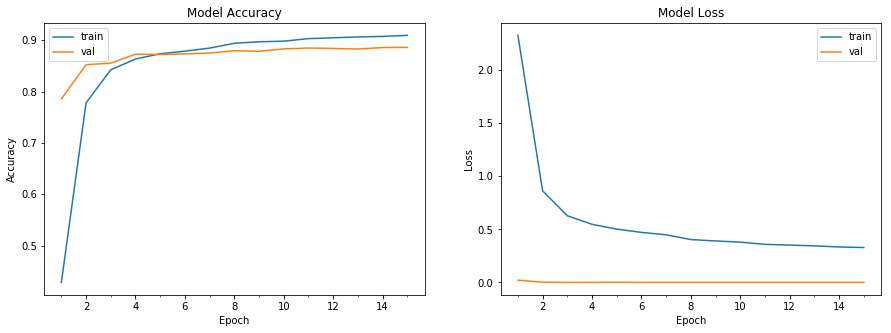

105/105 [==============================] - 5s 43ms/step


/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


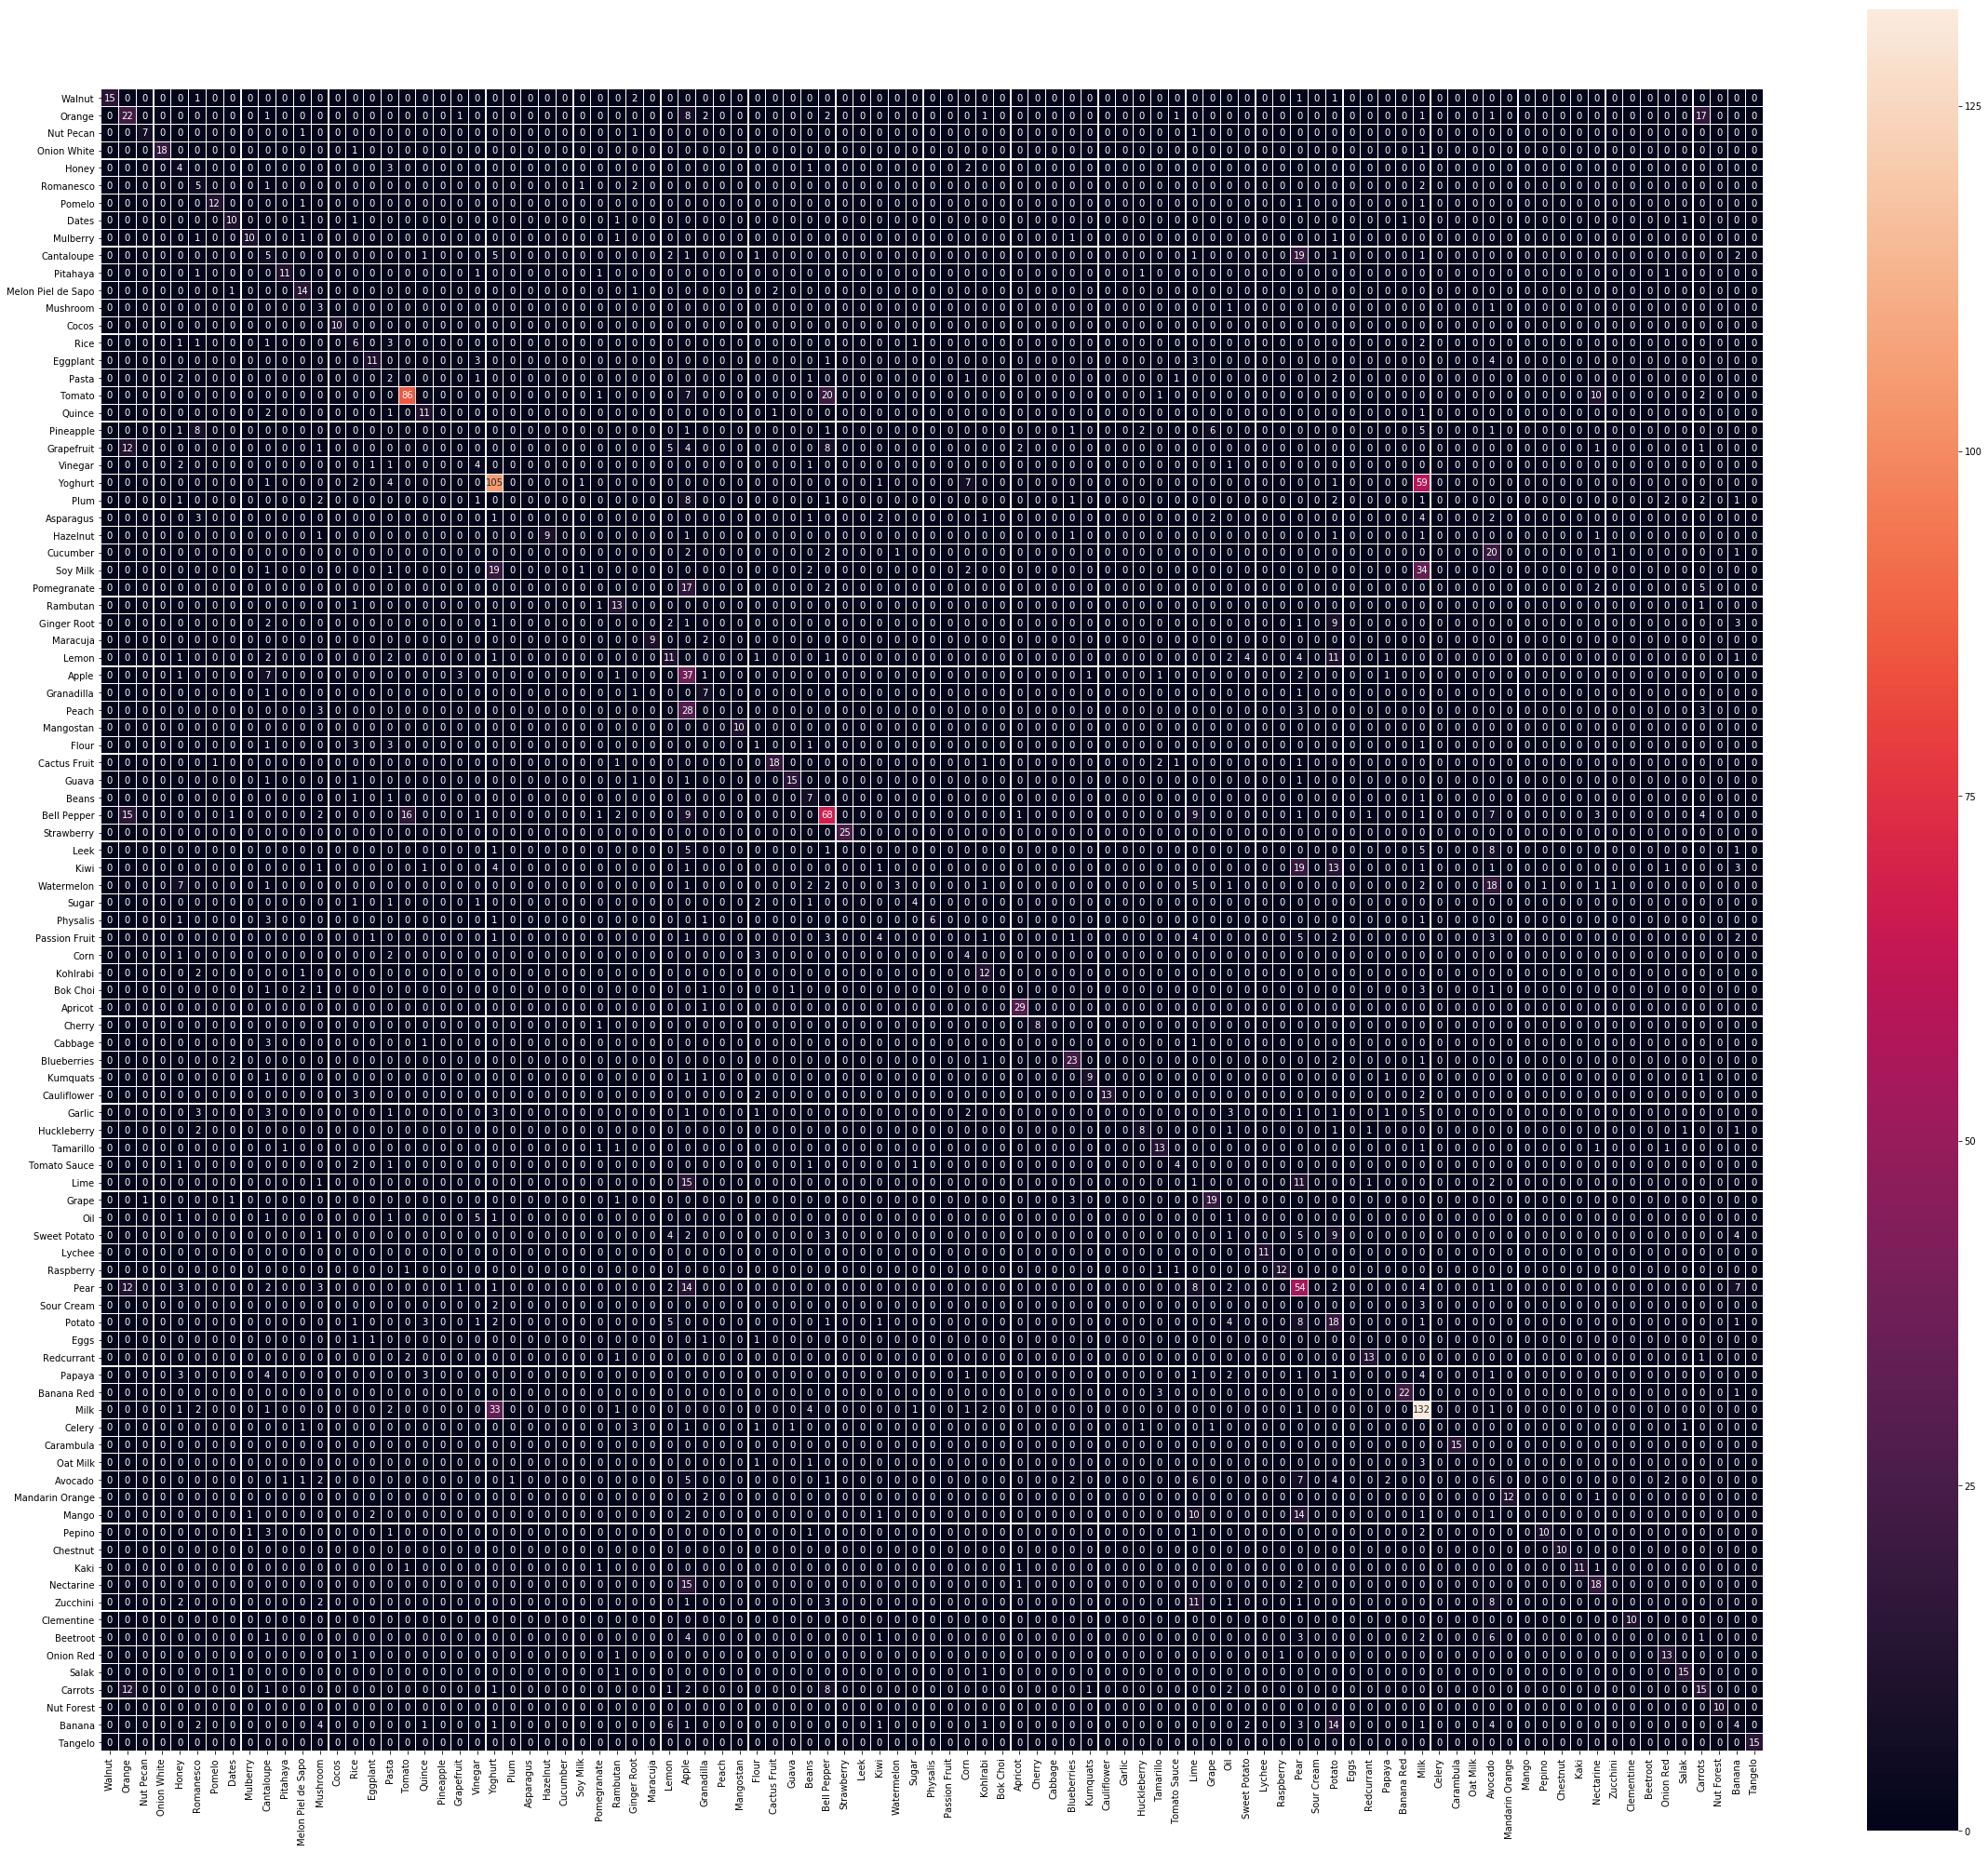

In [9]:
# Model set up and learning: Base Model (CNN + FF with Softmax Activation)
# Based on https://github.com/Horea94/Fruit-Images-Dataset

def image_process(x):
    '''
    Creates a custom layer that converts the original image from 
    RGB to HSV and grayscale and concatenates the results
    '''
    import tensorflow as tf # needs to be in here, when loading the model back in
    
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    image = tf.concat([hsv, gray], axis=-1)
    return image


def cnn_softmax_model(input_shape, num_classes):
    '''
    The Model: 
    - CNN with relu activation and max pooling, 5 CNN layers
    - 3 feed forward layers with dropout with one softmax activation afterward
    '''
    
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(image_process)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Conv2D(254, (5, 5), strides=(1, 1), padding='same', name='conv5')(x)
    x = Activation('relu', name='conv5_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool5')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(500, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    x = Dense(200, activation='relu', name='fcl3')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    model = Model(inputs=img_input, outputs=out)
    return model

# Training and evaluating the model
model = cnn_softmax_model(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="ingredients_detection_model",  loss="sparse_categorical_crossentropy")

In [ ]:
# Model set up and learning: With SVM
# Based on https://github.com/Horea94/Fruit-Images-Dataset
from keras.regularizers import l2

def image_process(x):
    '''
    Creates a custom layer that converts the original image from 
    RGB to HSV and grayscale and concatenates the results
    '''
    import tensorflow as tf # needs to be in here, when loading the model back in
    
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    image = tf.concat([hsv, gray], axis=-1)
    return image


def cnn_svm_model(input_shape, num_classes):
    '''
    The Model: 
    - CNN with relu activation and max pooling, 6 CNN layers
    - 3 feed forward layers with dropout with one softmax activation afterward
    '''
    
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(image_process)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Conv2D(254, (5, 5), strides=(1, 1), padding='same', name='conv5')(x)
    x = Activation('relu', name='conv5_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool5')(x)
    x = Conv2D(508, (5, 5), strides=(1, 1), padding='same', name='conv6')(x)
    x = Activation('relu', name='conv6_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool6')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(500, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    x = Dense(200, activation='relu', name='fcl3')(x)
    x = Dropout(0.2)(x)
    x = Dense(num_classes, name='svm', W_regularizer=l2(weight))(x)
    out = Dense(num_classes, activation='softmax', name='prediction')(x)
    model = Model(inputs=img_input, outputs=out)
    return model

# Training and evaluating the model
model = cnn_svm_model(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="ingredients_detection_model_hinge", loss='categorical_hinge')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(95, kernel_regularizer=<keras.reg..., name="svm")`


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 100, 100, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 100, 100, 4)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1616      
_________________________________________________________________
conv1_relu (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 50, 50, 32)        12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 50, 50, 32)        0   

In [ ]:
# Experimental
# Set-up for model
# Based on https://github.com/Horea94/Fruit-Images-Dataset

# Setting up output folder
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loading labels
if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.rstrip('\n') for x in f.readlines()]
else:
    labels = os.listdir(train_dir)
    
num_classes = len(labels)

# Functions for plotting, data generator and model evaluation
def plot_model_history(model_history, out_path=""):
    '''
    Creating one accuracy and one loss chart over epochs
    '''
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))
    axs[1].legend(['train', 'val'], loc='best')
    
    # save the graph in a file called "acc_loss.png" to be available for later
    # the model_name is provided when creating and training a model
    if out_path:
        plt.savefig(out_path + "/acc_loss.png")
    plt.show()


def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    '''
    Creates a confusion matrix to visually represent incorrectly classified images
    '''
    
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(40, 40))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=0.2, cbar_kws={"shrink": 0.9})
    
    if out_path:
        plt.savefig(out_path + "/confusion_matrix.png")  # as in the plot_model_history, the matrix is saved in a file called "model_name_confusion_matrix.png"
    
    return ax


# builds a training and validation generator
def build_data_generators(train_folder, test_folder, validation_percent=0.2, labels=None, 
                          image_size=image_size, batch_size=50):
    '''
    Builds training and validation generator from training dataset
    '''
    
    # It should randomly flip images
    train_datagen = ImageDataGenerator(
        width_shift_range=0.0,
        height_shift_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,  
        validation_split=validation_percent)

    train_gen = train_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=True, 
                                                  subset='training', classes=labels)
    
    validation_gen = train_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                       batch_size=batch_size, shuffle=False, 
                                                       subset='validation', classes=labels)
    test_datagen = ImageDataGenerator()
    
    test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=False, subset=None, classes=labels)
    
    return train_gen, validation_gen, test_gen


def train_and_evaluate_model(model, name="", epochs=epochs, batch_size=batch_size, 
                             validation_percent=validation_percent, verbose=verbose, 
                             loss='categorical_hinge', use_checkpoint=False):
    '''
    Training and evaluating the model
    
    The batch size is used to determine the number of images passed through the network at once, 
    the number of steps per epochs is derived from this as (total number of images in set // batch size) + 1
    '''
    
    print(model.summary())
    
    model_out_dir = os.path.join(output_dir, name)
    
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)
        
    if use_checkpoint:
        model.load_weights(model_out_dir + "/model.h5")

    trainGen, validationGen, testGen = build_data_generators(train_dir, test_dir, validation_percent=validation_percent, 
                                                    labels=labels, image_size=image_size, batch_size=batch_size)
    
    print('Training directory:\n', train_dir)
    
    optimizer = Adadelta(lr=learning_rate)
    
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose, 
                                                factor=learning_rate_reduction_factor, min_lr=min_learning_rate)
    
    save_model = ModelCheckpoint(filepath=model_out_dir + "/model.h5", monitor='val_accuracy', verbose=verbose, 
                                 save_best_only=True, save_weights_only=False, mode='max', period=1)
    
    history = model.fit_generator(generator=trainGen,
                                  epochs=epochs,
                                  steps_per_epoch=(trainGen.n // batch_size) + 1,
                                  validation_data=validationGen,
                                  validation_steps=(validationGen.n // batch_size) + 1,
                                  verbose=verbose,
                                  callbacks=[learning_rate_reduction, save_model])

    model.load_weights(model_out_dir + "/model.h5")

    validationGen.reset()
    loss_v, accuracy_v = model.evaluate_generator(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)
    
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    
    loss_t, accuracy_t = model.evaluate_generator(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    
    print("Hold out set: accuracy = %f  ;  loss = %f" % (loss_t, accuracy_t))
    
    plot_model_history(history, out_path=model_out_dir)
    
    testGen.reset()
    y_pred = model.predict_generator(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    y_true = testGen.classes[testGen.index_array]
    
    plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, out_path=model_out_dir)
    class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)

    with open(model_out_dir + "/classification_report.txt", "w") as text_file:
        text_file.write("%s" % class_report)

def image_process(x):
    '''
    Creates a custom layer that converts the original image from 
    RGB to HSV and grayscale and concatenates the results
    '''
    import tensorflow as tf # needs to be in here, when loading the model back in
    
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    image = tf.concat([hsv, gray], axis=-1)
    return image


def cnn_softmax_model(input_shape, num_classes):
    '''
    The Model: 
    - CNN with relu activation and max pooling, 5 CNN layers
    - 3 feed forward layers with dropout with one softmax activation afterward
    '''
    
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(image_process)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Conv2D(254, (5, 5), strides=(1, 1), padding='same', name='conv5')(x)
    x = Activation('relu', name='conv5_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool5')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(500, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    x = Dense(200, activation='relu', name='fcl3')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    model = Model(inputs=img_input, outputs=out)
    return model

# Training and evaluating the model
model = cnn_softmax_model(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="ingredients_detection_model_experimental",  loss="sparse_categorical_crossentropy")

In [ ]:
# Making single image predictions
# Loading model
import sys
from keras.models import load_model
from keras.optimizers import Adadelta
import cv2
import numpy as np
import os

# load model
model = load_model('/home/miber/creative-cooking/ingredients_training_output_files/ingredients_detection_model/model.h5')

# Load and resize image
image_size = (100, 100)
input_shape = (1, 100, 100, 3) 

#image = '/home/miber/data/ingredients-images/ingredients-train/Apple/0_100.jpg'
image = '/home/miber/data/ingredients-images/ingredients-train/Banana/222_100.jpg'
image = cv2.imread(image)
image = cv2.resize(image,image_size)
image = np.reshape(image, input_shape)

# Run model
learning_rate = 0.1
optimizer = Adadelta(lr=learning_rate)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

prediction = model.predict(image)

# Format prediction
label_file = '/home/miber/creative-cooking/labels.txt'

with open(label_file, "r") as f:
    labels = [x.rstrip('\n') for x in f.readlines()]

print('Prediction Ingredient:')

for ingredient, prob in sorted(list(zip(labels, prediction[0])), key = lambda x: -x[1])[:5]:
    print('{}: {:.2f}%'.format(ingredient, round(prob, 4) * 100))

In [ ]:
!python3 ./ingredients-prediction.py /home/miber/data/ingredients-images/ingredients-train/Apple/0_100.jpg